In [1]:
import math
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import rebound as rb

In [ ]:
"""Intro to Rebound"""

"""Question 2"""

sim = rb.Simulation()

sim.move_to_com()
sim.integrator = "whfast"

sim.add(m=1, hash="Binary 1")
sim.add(m=1, a=1, e= 0.1, hash="Binary 2", f=np.random.rand()*2*np.pi)
sim.add(a=2.5, e= 0.4, hash="Test Planet", f=np.random.rand()*2*np.pi)

spec_int = np.pi # half of one full orbit

N_orbit = 6*np.pi #3 full orbits

sim.integrate(N_orbit, exact_finish_time=0) #setting flag to integrate up to timestep nearest to endtime
sim.dt = 1e-3

sim.exit_max_distance = 4*1

In [ ]:
sim.status()

In [ ]:
print(sim.particles[1].a)

In [ ]:
"""Question 3"""

sim2 = rb.Simulation()

sim2.move_to_com()
sim2.integrator = "whfast"

sim2.add(m=1, hash="Binary 1")
sim2.add(m=1, hash="Binary 2", a=1, e=0.5)
sim2.add(hash="Planet", a=4, e=0)

N2_orbit = 10*2*np.pi
sim2.dt = 1e-3

In [ ]:
sim2.status()

In [ ]:
%matplotlib inline

fig = rb.OrbitPlot(sim2)
plt.savefig('orbitalplot.pdf')

In [ ]:
particles2 = sim2.particles
fig, ax = plt.subplots()
ax.plot()

torb = 6*np.pi
Noutputs = 100
times = np.linspace(0, torb, Noutputs)

b1x = []
b1y = []

b2x = []
b2y = []

px = []
py = []


sim2.move_to_com()
for i, time in enumerate(times):
    sim2.integrate(time,exact_finish_time=0)
    b1x.append(particles2[0].x)
    b1y.append(particles2[0].y)
    b2x.append(particles2[1].x)
    b2y.append(particles2[1].y)
    px.append(particles2[2].x)
    py.append(particles2[2].y)

plt.plot(b1x,b1y, color='green')
plt.plot(b2x,b2y, color='cyan')
plt.plot(px,py, color='pink')   
plt.xlabel("x")
plt.ylabel("y")
plt.title("Manual Orbital Plot")

In [ ]:
sim2.status()

In [1]:
import math
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import rebound as rb

In [2]:
"""Classic Results"""

""" Question 1"""

# tuples are of order (e_b, a_p) binary eccentricity and planetary semi-major axis

tup_num = 2
e_b = np.linspace(0, 0.7, tup_num)
a_p = np.linspace(1, 5, tup_num)
Np = 5
tup_list = []

for e in e_b:
    for a in a_p:
        tup_list.append((e,a,Np))

def survival(initial):    
    (eb, ap, Np) = initial

    sim = rb.Simulation()
    sim.integrator = "whfast"
    
    sim.add(m=1, hash="Binary 1")
    sim.add(m=1, a=1, e= eb, hash="Binary 2")
    
    #initializing Np massless planets
    f_plan = np.random.rand()*2*np.pi
    for p in range(Np):
        sim.add(a= ap, e=0, hash="Test Planet", f= f_plan)
    
    #array to keep track of survival times
    surv = np.zeros([Np])
    
    sim.move_to_com()
    
    #integrate
    N_orbit = (10e4)*2*np.pi
    times = np.linspace(0,N_orbit,100000)
    
    for i, time in enumerate(times):
        if not i%10000: 
            print(f't={time/2/np.pi:.2f}') #let me know things are going well
        sim.integrate(time, exact_finish_time=0)
                              
        for j,p in enumerate(sim.particles[2:]):                  
            p = sim.particles[2]
            a_bin = sim.particles[1].a
            
            if (p.x**2 + p.y**2) > (100*a_bin)**2:
                surv[j] = time
                print(f'removing planet {j+2}')
                sim.remove(j+2) 
        # if all particles have been ejected, end integration
        if len(sim.particles)==2:
            break
    sim.save(checkpoint.bin)
    surv[(surv==0)] = time
    
    print(f'simulation finished, {len(sim.particles)-2} planets remaining')
    return np.mean(surv)

In [3]:
%%time
pool = rb.InterruptiblePool()
mapping = pool.map(func= survival, iterable= tup_list)

t=0.00
t=0.00
t=0.00
t=0.00


Process ForkPoolWorker-4:
Process ForkPoolWorker-2:
Process ForkPoolWorker-1:
Process ForkPoolWorker-3:


KeyboardInterrupt: 

In [4]:
fig = plt.figure()
figure = np.reshape(mapping, [tup_num,tup_num])

plt.pcolormesh(e_bin,a_plan, figure.T, shading='auto')
plt.title('Mean Survival Times')
plt.xlabel('Binary Eccentricity (e)')
plt.ylabel('Planetary Semi-Major Axis (a)')
plt.xlim(0.0,0.7)
plt.ylim(1,5)

a_bin = 2.278 + 3.824*e_bin - 1.71*(e_bin**2)
plt.plot(e_bin, a_bin, color='white')
plt.scatter(e_bin, a_bin, color='white')

plt.colorbar(label='Test Particle Survival Times')

NameError: name 'mapping' is not defined

<Figure size 432x288 with 0 Axes>

Text(0, 0.5, 'Energy Error')

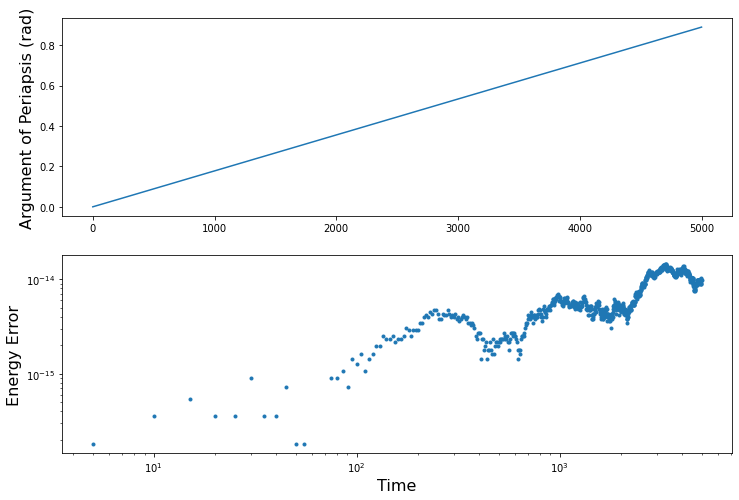

In [3]:
""" Including Tides"""
""" Question 1 """

import reboundx as rx

def getsim():
    sim = rb.Simulation()
    sim.units = ('yr', 'AU', 'Msun')
    sim.add(m=1, r=0.1, hash="Binary 1")
    sim.add(m=1, r=0.1, a=1, e= 0.1, hash="Binary 2", f=np.random.rand()*2*np.pi)
    sim.move_to_com()
    rebx = rx.Extras(sim)
    tides = rebx.load_force("tides_constant_time_lag")
    rebx.add_force(tides)
    # stop simulation when the binaries collide
    
    return sim, rebx, tides

sim, rebx, tides = getsim()
ps = sim.particles
ps[0].params["tctl_k1"] = 0.25
# tau is zero for now as it's not specified

H0 = sim.calculate_energy() + rebx.tides_constant_time_lag_potential(tides)
tmax = 5000
Nout=1000

pomega, Eerr = np.zeros(Nout), np.zeros(Nout)
times = np.linspace(0,tmax,Nout)

for i, time in enumerate(times):
    sim.integrate(time)
    pomega[i] = ps[1].pomega
    H = sim.calculate_energy() + rebx.tides_constant_time_lag_potential(tides)
    Eerr[i] = abs((H-H0)/H0)
    
fig, axarr = plt.subplots(nrows=2, figsize=(12,8))
axarr[0].plot(times, pomega)
axarr[0].set_ylabel("Argument of Periapsis (rad)", fontsize=16)
axarr[1].plot(times, Eerr, '.')
axarr[1].set_xscale('log')
axarr[1].set_yscale('log')
axarr[1].set_xlabel('Time', fontsize=16)
axarr[1].set_ylabel('Energy Error', fontsize=16)

In [ ]:
""" What happens to the binary orbit over time when tau is zero?"""
"""While tau  is equal to zero, the system is in a state of instantaneous equilibrium
 tides where total energy is conserved, although the pericenter (focus closess to the center of mass)
 will precess. The pericenter vs. time graph illustrates this, showing that over time the 
 argument of the periapsis monotoncally increases indicating that the direction of the periapse
 and consequently the apoapsis are changing. 
 So, over time the binary orbit will rotate about the center of mass
 as the periapsis precesses while the semi-major axis and the eccentricity
 remain constant.
 """ 

In [4]:
sim, rebx, tides = getsim()
ps = sim.particles
ps[0].params["tctl_k1"] = 0.25
ps[0].params["tctl_tau"] = 1e-3
ps[0].params["Omega"] = 1e-5

tmax = 2.5e4
Nout= 1000

a, e = np.zeros(Nout), np.zeros(Nout)
times = np.linspace(0,tmax,Nout)
# to plot physical radius of the Sun

R0 = 0*times + ps[0].r

q = (ps[1].m/ps[0].m)
T = ps[0].r**3/sim.G/ps[0].m/ps[0].params["tctl_tau"]
apred = ps[0].r*((ps[1].a/ps[0].r)**8 - 48.*ps[0].params["tctl_k1"]*q*(1+q)*times/T)**(1./8.)

In [5]:
%%time
for i, time in enumerate(times):
    sim.integrate(time)
    a[i] = ps[1].a
    e[i] = ps[1].e

CPU times: user 44.4 s, sys: 0 ns, total: 44.4 s
Wall time: 44.4 s


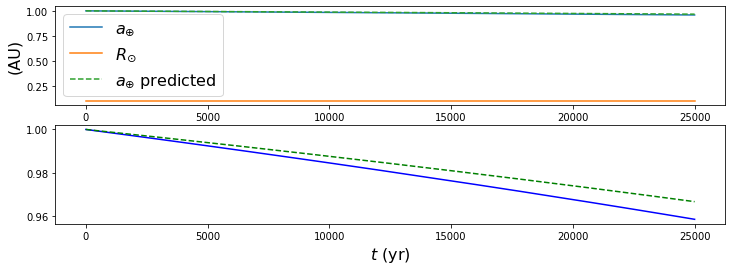

In [6]:
fig, ax = plt.subplots(2, figsize=(12,4))
ax[0].plot(times, a, label='$a_{\oplus}$')
ax[0].plot(times, R0, label='$R_{\odot}$')
ax[0].plot(times, apred, '--', label='$a_{\oplus}$ predicted')

plt.xlabel('$t$ (yr)', fontsize=16)
ax[0].set_ylabel('(AU)', fontsize=16)

ax[0].legend(fontsize=16, loc='best')

#ax[1].legend(fontsize=16, loc='best')
ax[1].plot(times, a, color='blue')
ax[1].plot(times, apred, '--', color='green')

Text(0.5, 1.0, 'Evolution of Eccentricity')

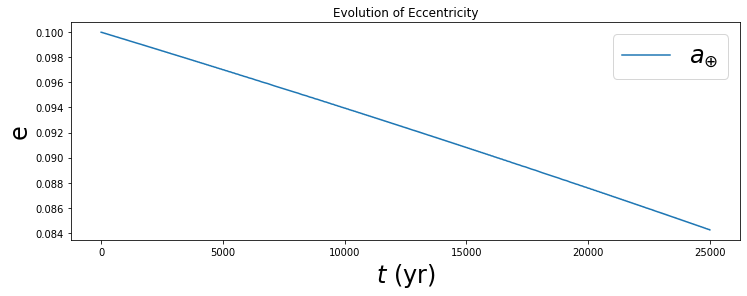

In [7]:
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(times, e, label='$a_{\oplus}$')
ax.set_xlabel('$t$ (yr)', fontsize=24)
ax.set_ylabel('e', fontsize=24)
ax.legend(fontsize=24, loc='best')
ax.set_title('Evolution of Eccentricity')

In [ ]:
""" How does adding a non-zero tau value change the evolution of the orbital
parameters over time?"""
""" Both the semi major axis and the eccentricity decrease over time
when tau becomes a non-zero value."""

In [8]:
""" Observational Constraints on Stability"""
import emcee 

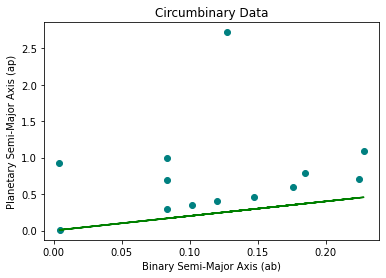

In [9]:
a_b = np.array([0.0043, 0.2243, 0.1276, 0.228,
               0.1762, 0.147, 0.1015, 0.0041,
               0.1848, 0.0836, 0.0836, 0.0836,
               0.12])
a_p = np.array([0.0088, 0.7048, 2.72, 1.0896,
               0.6035, 0.4644, 0.353, 0.92,
               0.7903, 0.2956, 1, 0.6992, 0.4])

plt.figure()
plt.title('Circumbinary Data')
plt.xlabel('Binary Semi-Major Axis (ab)')
plt.ylabel('Planetary Semi-Major Axis (ap)')
plt.scatter(a_b, a_p, color='teal')

# plot the line a_p = 2a_b
plt.plot(a_b, 2*a_b, color='green')

In [ ]:
""" Yes there seems to be a pile-up of circumbinary planets
around a_p = 2a_b"""

In [10]:
a_i = a_p/a_b
a_c = 2*a_b

def log_prior(a_c):
    array = []
    for num in a_c:
        if 1 < num <= 5:
            array.append(0)
        array.append(-np.inf)
    return array

def log_likelihood(a_c, a_i):
    array = []
    for flt, num in zip(a_c, a_i):
        if num >= flt:
            array.append(0)
        else:
            array.append(-np.inf)
    return array

def log_probability(a_c, a_i):
    p_array = []
    lp = log_prior(a_c)
    ll = log_likelihood(a_c, a_i)

    for p,l in zip(lp,ll):
        if np.isfinite(lp) is False:
            p_array.append(-np.inf)
        p_array.append(p + l)
    return p_array

ac_in = 2.0
pos = ac_in + 1e-4 * np.random.randn(32,1)
nwalkers, ndim = pos.shape

In [11]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(a_i,))
sampler.run_mcmc(pos, 5000, progress=True)

100%|██████████| 5000/5000 [00:08<00:00, 580.58it/s]


State([[1.10287981]
 [1.78855603]
 [1.30078331]
 [1.24064265]
 [1.14495072]
 [1.00971978]
 [1.21874967]
 [1.32737162]
 [1.04399859]
 [1.63361257]
 [1.81622744]
 [1.46212585]
 [1.04938107]
 [1.9426438 ]
 [1.20313925]
 [1.24229078]
 [1.62634025]
 [1.9506551 ]
 [1.37325199]
 [1.28598238]
 [1.05502833]
 [1.02783327]
 [1.7010939 ]
 [1.9483085 ]
 [1.10493682]
 [2.0351729 ]
 [1.8916505 ]
 [1.44322814]
 [1.26866393]
 [1.98481797]
 [1.36966077]
 [1.04385883]], log_prob=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.], blobs=[], random_state=('MT19937', array([3987288936, 3658724817,  688002855,  535247175, 3242540266,
       1255721511,  872036342,  941511196,   44422029, 3010413488,
       2667929561, 1643643352, 3296021934,  213077278, 3121213585,
       1947598661, 1575967604,  118000402, 1111700781,  267364017,
       2379409285, 3507801188, 3707271967, 2238349597, 4052894723,
        344208780, 1862887315, 4019778332,  937388345, 4105571982

Text(0.5, 0, 'step number')

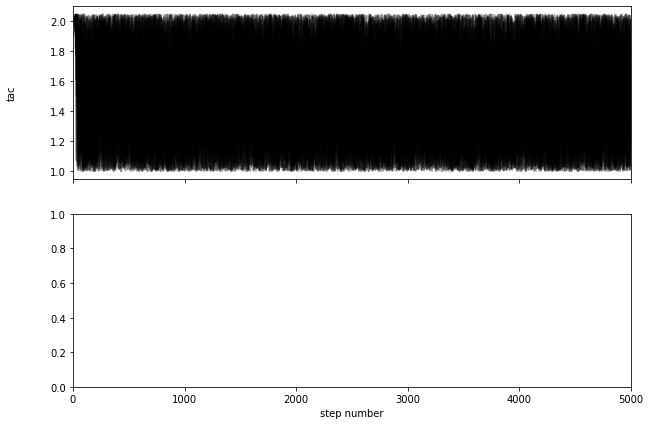

In [12]:
fig, axes = plt.subplots(2,figsize=(10,7), sharex = True)
samples = sampler.get_chain()
label = ["tac"]

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(label[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number")

In [ ]:
""" The values of ~ac (tac) seem to be constrained to values 
1.0 < tac < 2.0 based on the plot above."""

In [13]:
tau = sampler.get_autocorr_time()
print(tau)

[25.9303959]


In [14]:
flat_samples = sampler.get_chain(discard=100, thin=13, flat=True)
print(flat_samples.shape)

(12032, 1)


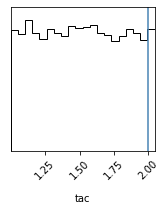

In [15]:
import corner

fig = corner.corner(flat_samples, labels=label, truths=[ac_in])

In [16]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [50, 75, 95])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], label)
    display(Math(txt))

<IPython.core.display.Math object>

In [ ]:
""" Based on the statistical analysis, ~a_c is constrained to 1.790 based on the above observations.
My intuition had me believe that the value was 1.5 since the range seemed to be split equally, more or less, between 1.0 and 2.0.
Although, the statistical constraints using data gave me a consicise estimate in addition to accounting for errors in measurement."""